# Isolating perturbation-induced variations with contrastiveVI

Perturb-seq is a platform for conducting large scale CRISPR-mediated gene perturbation screens in single-cells. A major goal of Perturb-seq experiments is to gain new insights as to gene functions (e.g. pathway membership) and the relationships between different genes. Unfortunately, analyzing the effects of CRISPR perturbation in Perturb-seq experiments can be confounded by sources of variation shared with control cells (e.g. cell-cycle-related variations).

Here we illustrate how contrastiveVI's explicit deconvolution of shared and perturbed-cell-specific variations can overcome such challenges in the analysis of Perturb-seq data. For this case study, we'll consider data from a large-scale Perturb-seq experiment originally collected in [Norman et al.](https://www.science.org/doi/10.1126/science.aax4438) In this study the authors assessed the effects of 284 different CRISPR-mediated perturbations on the growth of K562 cells, where each perturbation induced the overexpression of a single gene or a pair of genes.

If you use contrastiveVI in your work, please consider citing:

- Weinberger, E., Lin, C. & Lee, SI. Isolating salient variations of interest in single-cell data with contrastiveVI. Nature Methods 20, 1336–1345 (2023).

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

## Imports and data loading

In [2]:
import os
import tempfile

import numpy as np
import requests
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

This dataset was filtered as described in the contrastiveVI manuscript (low quality cells filtered out, high variable gene selection, etc.). Normalized, log-transformed values can  be found in `adata.X`, while raw counts can be found in `adata.layers['count']`.

In [5]:
adata_path = os.path.join(save_dir.name, "norman_2019.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/43390776",
)
adata.var_names = adata.var["gene_name"]

del adata.raw  # Save memory to stay within Colab free tier limits

  0%|          | 0.00/3.89G [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


As an extra preprocessing step, we'll calculate cell cycle labels to be used later in our analysis:

In [6]:
def get_cell_cycle_genes() -> list:
    # Canonical list of cell cycle genes
    url = "https://raw.githubusercontent.com/scverse/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt"
    cell_cycle_genes = requests.get(url).text.split("\n")[:-1]
    return cell_cycle_genes

In [7]:
cell_cycle_genes = get_cell_cycle_genes()

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)

Now let's briefly take a look at our data. In their original work Norman et al. labeled groups of perturbations with similar induced gene programs (e.g. inducing expression of megakaryocyte markers). Thus, we would expect perturbed cells to separate by these program labels (found in `adata.obs['gene_program']`).

However, contrary to our prior knowledge, we find that perturbed cells do not clearly separate by our gene program labels, and instead separate by confounding variations shared with controls, such as cell cycle phase.

         Falling back to preprocessing with `sc.pp.pca` and default params.


/env/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired 

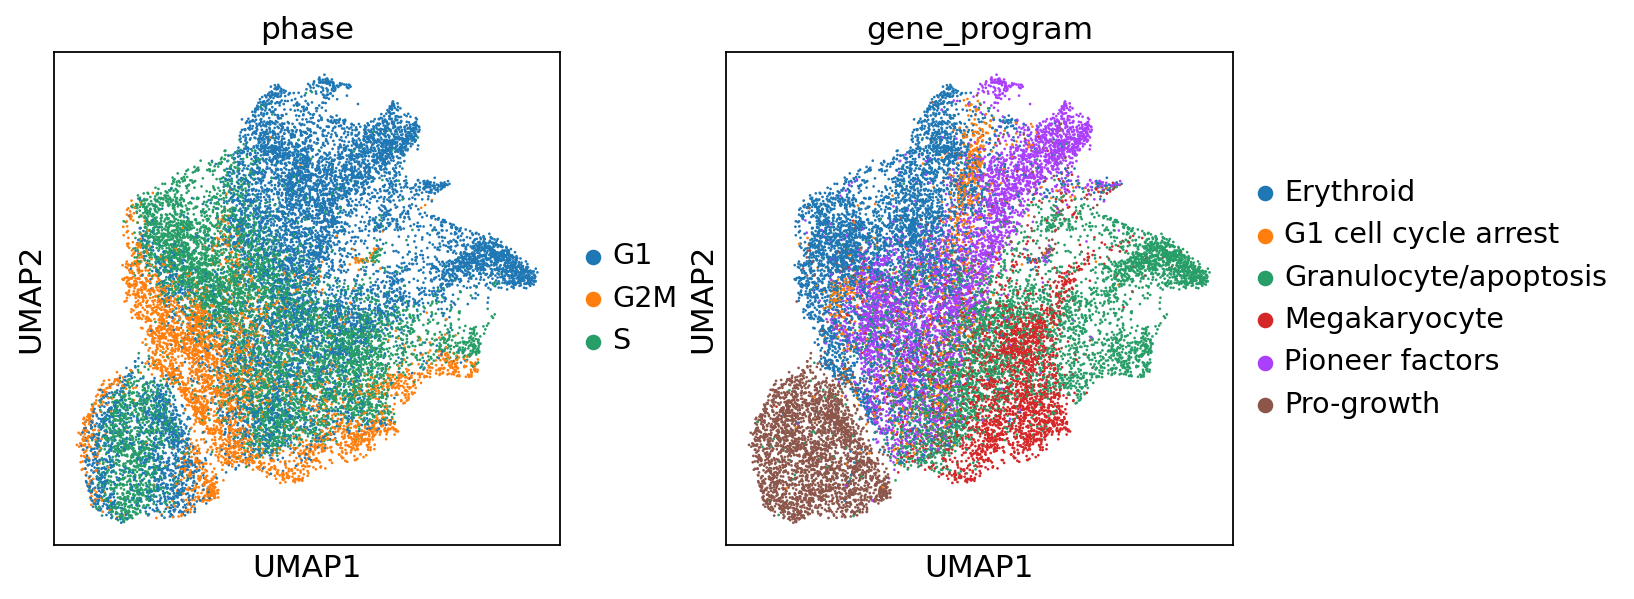

In [8]:
perturbed_adata = adata[
    adata.obs["gene_program"] != "Ctrl"
]  # Only consider perturbed cells

sc.pp.neighbors(perturbed_adata)
sc.tl.umap(perturbed_adata)
sc.pl.umap(perturbed_adata, color=["phase", "gene_program"])

In the next section, we'll see how to use contrastiveVI to alleviate such issues

## Prepare and run model

In [9]:
scvi.external.ContrastiveVI.setup_anndata(adata, layer="count")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



contrastiveVI explicitly isolates perturbed-cell-specific variations from variations shared with controls by assuming that the data is generated from two sets of latent variables. The first, called the **_background_** variables, are shared across perturbed and control cells. The second, called the **_salient_** variables, are only active in perturbed cells and are fixed at 0 for controls.

Because contrastiveVI uses a single decoder network to reconstruct all cells, the background variables are naturally encouraged during training to capture patterns shared across all cells, while the salient variables instead pick up the remaining perturbed-cell-specific variations (see the contrastiveVI manuscript for additional details).

In [10]:
contrastive_vi_model = scvi.external.ContrastiveVI(
    adata, n_salient_latent=10, n_background_latent=10, use_observed_lib_size=False
)

Before training, we thus need to tell contrastiveVI which cells are only generated from background (i.e., control cells), and which cells are our target (i.e., perturbed cells).

In [11]:
background_indices = np.where(adata.obs["gene_program"] == "Ctrl")[0]
target_indices = np.where(adata.obs["gene_program"] != "Ctrl")[0]

In [12]:
contrastive_vi_model.train(
    background_indices=background_indices,
    target_indices=target_indices,
    early_stopping=True,
    max_epochs=500,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 2/500:   0%|          | 1/500 [00:02<16:46,  2.02s/it, v_num=1, train_loss_step=4.17e+3, train_loss_epoch=1.48e+4]

/env/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 87. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/env/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 472/500:  94%|█████████▍| 472/500 [11:28<00:40,  1.46s/it, v_num=1, train_loss_step=2.85e+3, train_loss_epoch=2.85e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2876.382. Signaling Trainer to stop.


Now let's get the salient representation of our perturbed cells.

In [13]:
perturbed_adata.obsm["salient_rep"] = contrastive_vi_model.get_latent_representation(
    perturbed_adata, representation_kind="salient"
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Visualizing these salient representations, we find that they're invariant to the confounding cell-cycle-related variations and now separate clearly by gene program label as desired.

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

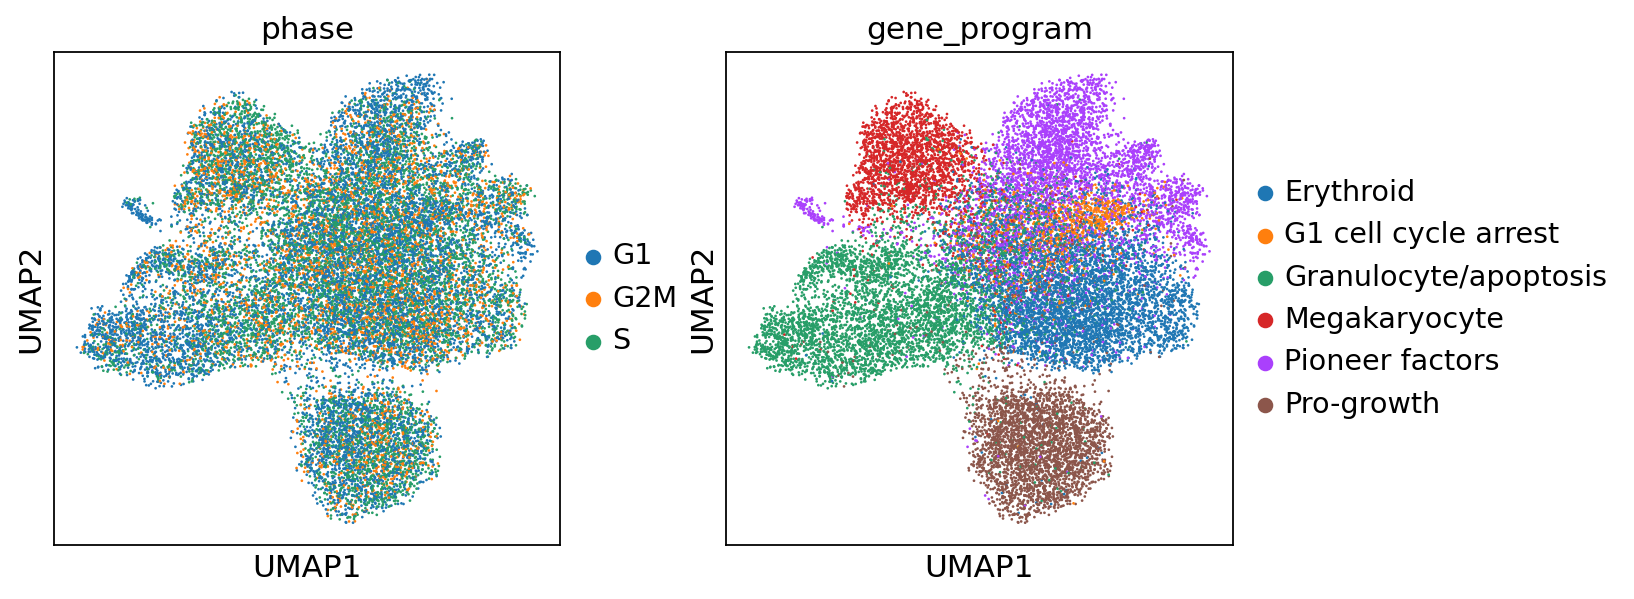

In [14]:
sc.pp.neighbors(perturbed_adata, use_rep="salient_rep")
sc.tl.umap(perturbed_adata)
sc.pl.umap(perturbed_adata, color=["phase", "gene_program"])